## Load modules

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image

## Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

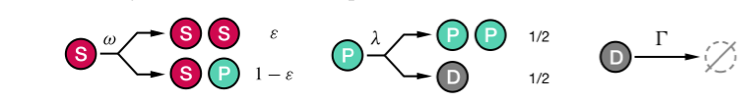

In [2]:
Image("cell_division.png")


In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * epsilon
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - epsilon)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma
    
For each simulation, 
    
    1. the propensity function for each reaction is calculated based of the number reactant cells (S, P, D) in the population and the rate of reaction;
    2. a first random number is generated to decide time for next reaction;
    3. a second random number is generated to decide which reaction occurs next;
    4. as the reaction occurs, the number of cells (reactant and product) in the population is updated.

## Simulating the clonal size at counting time point

In [3]:
def clonalSizeSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint,seed):
    S = 1
    P = 0
    D = 0
    reactionTime = 0
    random.seed(seed)
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate

    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > countingTimePoint:
            N = S + P + D
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
#             random.seed(seed+1)
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2+A3)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P -= 1
                D += 1
            else:
                D -= 1
            N = S + P + D
#             print('reaction time = ' + str(reactionTime))
#             print('clone size = ' + str(N))
    return(N)

testingSizes = clonalSizeSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=50,seed=5)
print(testingSizes)

11


## Multiple simulation

In Lan et al.'s study, the stem cell hierarchy model was simulated for 10^5 times. This large sample size will produce a distribution of clone sizes.

CPU times: user 5.13 s, sys: 18.7 ms, total: 5.15 s
Wall time: 5.17 s


(array([563., 198., 106.,  55.,  33.,  23.,  10.,   6.,   1.,   5.]),
 array([  1. ,  48.2,  95.4, 142.6, 189.8, 237. , 284.2, 331.4, 378.6,
        425.8, 473. ]),
 <a list of 10 Patch objects>)

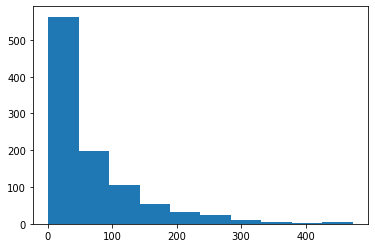

In [4]:
def multiSimulation(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = clonalSizeSimulation(stemDivRate=0.15, epsilon=0.15, proDivRate=1.0, apoptosisRate=0.48,countingTimePoint=80, seed=n*simulation+i)
    return(clones)

%time testing = multiSimulation(5)
plt.hist(testing)

In [5]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time result = p.map(multiSimulation, range(10))

CPU times: user 17.4 ms, sys: 4.96 ms, total: 22.4 ms
Wall time: 23 s


(array([7.208e+03, 1.746e+03, 6.710e+02, 2.430e+02, 7.600e+01, 3.200e+01,
        1.400e+01, 4.000e+00, 2.000e+00, 4.000e+00]),
 array([  1. ,  78.4, 155.8, 233.2, 310.6, 388. , 465.4, 542.8, 620.2,
        697.6, 775. ]),
 <a list of 10 Patch objects>)

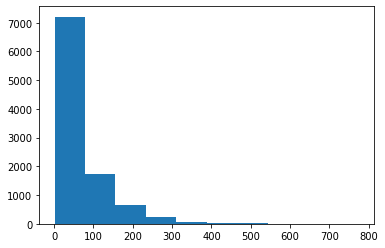

In [6]:
cloneSizes = np.concatenate(result)
plt.hist(cloneSizes)

In [7]:
print(np.mean(cloneSizes))

62.7452


## Negative Binomial Distribution

In Lan et al.'s experiments, the sizes of the tumour clones showed a negative binomial distribution (NBD). Therefore, the fitness of the simulated data to NBD is also checked.

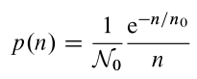

In [18]:
Image("NBD.png")

where  

    n = clone size,
    p(n) = the probability of having clone size of n,
    n0 = division rate of progenitor cell * t / 2,
    N0 = ln(n0)

In [9]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

cloneSizeRange = np.asarray(range(int(max(cloneSizes))))
NBD = negativeBinomialDistribution(divisionRate=1, countingTimePoint=80, n=cloneSizeRange)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


minimum clone size = 1
maximum clone size = 775


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


CPU times: user 2.35 s, sys: 19.4 ms, total: 2.37 s
Wall time: 2.4 s


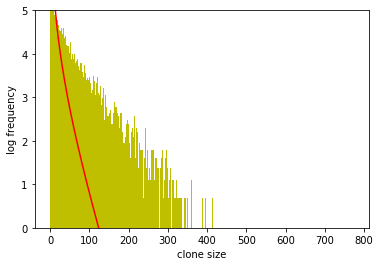

In [21]:
def logSizeDistribution(cloneSizes,NBD):
    minimum = int(min(cloneSizes))
    print('minimum clone size = ' + str(minimum))
    maximum = int(max(cloneSizes))
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(len(cloneSizes)*NBD), 'r')
    plt.ylim((0, 5))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')
    
%time logSizeDistribution(cloneSizes,NBD)

In Lan et al.'s paper, to further detect the NBD of clone sizes, first incomplete moment (FIM) was also applied. By definition, FIM gives the relative average clone size of all clones with sizes larger than n.

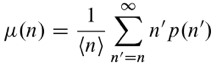

In [19]:
Image("FIM.png")

where

    <n> indicates the average clone size

If the clone size follows a negative binomial distribution, then FIM will follows an exponential distribution, which will be linear in a logarithm scale.

In [12]:
def firstIncompleteMoment(cloneSizes):
    maximum = int(max(cloneSizes))
    cloneSizeRange = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    prob = freq/sum(freq)
    averageCloneSize = np.mean(cloneSizes)
    step1 = np.array([i*p for (i,p) in enumerate(prob,1)])
    step2 = np.zeros(maximum)
    for i in range(maximum):
        step2[i]=step1[maximum-i-1]
    step3 = np.cumsum(step2)
    step4 = np.zeros(maximum)
    for i in range(maximum):
        step4[i]=step3[maximum-i-1]
    mu = step4/averageCloneSize
    return(mu)
    
%time mu = firstIncompleteMoment(cloneSizes)

CPU times: user 1.78 s, sys: 10.4 ms, total: 1.79 s
Wall time: 1.8 s


In [53]:
def logPlot(X,y):
    Y = np.log(y)
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(X,Y)
    print('slope = '+str(slope))
    plt.plot(X,Y,'b')
    plt.plot(X,slope*X+intercept,'r')
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')

slope = -0.008710512646309338


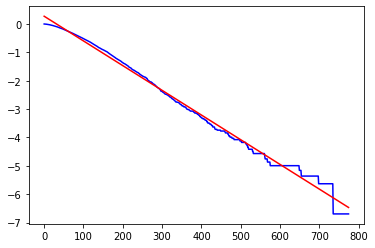

In [14]:
logPlot(cloneSizeRange,mu)

## Simulating the clonal size across passages

In Lan et al.'s experiment, about 5% of the harvesting cells are chosen for reinjection. These reinjected cells consist of stem cells and progenitor cell since differentiated cells were unlikely to survive during the process of serial transplantation. 

In [40]:
def harvestClones(inject, parameters,countingTimePoint,seed):
    stemDivRate = parameters["stem_div_rate"]
    epsilon = parameters["epsilon"]
    proDivRate = parameters["pro_div_rate"]
    apoptosisRate = parameters["apoptosis_rate"]
    countingTimePoint = countingTimePoint
    seed = seed
    S = inject["stem"]
    P = inject["progenitor"]
    D = inject["differentiated"]
    reactionTime = 0
    random.seed(seed)
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate

    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > countingTimePoint:
#             N = S + P + D
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
#             random.seed(seed+1)
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2+A3)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P -= 1
                D += 1
            else:
                D -= 1
#             N = S + P + D
#             print('reaction time = ' + str(reactionTime))
#             print('clone size = ' + str(N))
    return{"stem":S, "progenitor":P, "differentiated":D}
    
testingInject = {
    "stem":1,
    "progenitor":0,
    "differentiated":0}

testingParameters = {
    "stem_div_rate":0.15,
    "epsilon":0.15,
    "pro_div_rate":1.0,
    "apoptosis_rate":0.48}

testingClone = harvestClones(testingInject, testingParameters,80,0)
print(testingClone)

{'stem': 12, 'progenitor': 23, 'differentiated': 26}


In [78]:
def transplantation(harvest):
    stemHarvest = harvest["stem"]
    proHarvest = harvest["progenitor"]
    diffHarvest = harvest["differentiated"]    
    totalHarvest = stemHarvest + proHarvest + diffHarvest
    totalReinject = totalHarvest * 0.05
#    only stem cells and progenitor cells may survive during the process of serial transplantation. 
    if stemHarvest + proHarvest > 0:
        stemComposition = stemHarvest/(stemHarvest + proHarvest)
        proComposition = proHarvest/(stemHarvest + proHarvest)
    else:
        stemComposition = 0
        proComposition = 0
    stemReinject = round(stemComposition * totalReinject)
    proReinject = round(proComposition * totalReinject)
    return{"stem":stemReinject, "progenitor":proReinject, "differentiated":0}

testingReinject = transplantation(testingClone)
print(testingReinject)

{'stem': 1, 'progenitor': 2, 'differentiated': 0}


In [55]:
def secondaryPassage(primaryInject, parameters,seed):
    primaryHarvest = harvestClones(primaryInject, parameters,80,seed)
    secondaryInject = transplantation(primaryHarvest)
    secondaryHarvest = harvestClones(secondaryInject, parameters,65,seed)
    cloneSize = secondaryHarvest["stem"] + secondaryHarvest["progenitor"] + secondaryHarvest["differentiated"]
    return(cloneSize)

primaryInject = {
    "stem":1,
    "progenitor":0,
    "differentiated":0}

parameters = {
    "stem_div_rate":0.15,
    "epsilon":0.15,
    "pro_div_rate":1.0,
    "apoptosis_rate":0.48,
    "seed":0}

secondaryHarvest = secondaryPassage(primaryInject, parameters,0)
print(secondaryHarvest)

71


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 7.99 s, sys: 77.7 ms, total: 8.06 s
Wall time: 8.21 s


(array([808.,  96.,  59.,  18.,   9.,   3.,   3.,   2.,   1.,   1.]),
 array([  0. ,  64.5, 129. , 193.5, 258. , 322.5, 387. , 451.5, 516. ,
        580.5, 645. ]),
 <a list of 10 Patch objects>)

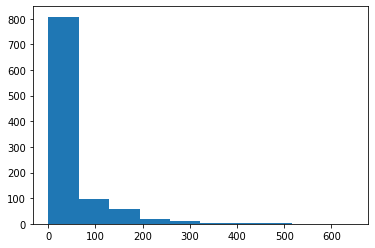

In [56]:
def multiSecondaryPassage(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = secondaryPassage(primaryInject=primaryInject, parameters=parameters,seed=n*simulation+i)
    return(clones)

%time testing = multiSecondaryPassage(0)
plt.hist(testing)

In [57]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time result = p.map(multiSecondaryPassage, range(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in

CPU times: user 42.5 ms, sys: 16.8 ms, total: 59.3 ms
Wall time: 48.9 s


(array([8.51e+03, 8.84e+02, 3.81e+02, 1.37e+02, 4.30e+01, 2.10e+01,
        1.10e+01, 8.00e+00, 3.00e+00, 2.00e+00]),
 array([  0. ,  85.7, 171.4, 257.1, 342.8, 428.5, 514.2, 599.9, 685.6,
        771.3, 857. ]),
 <a list of 10 Patch objects>)

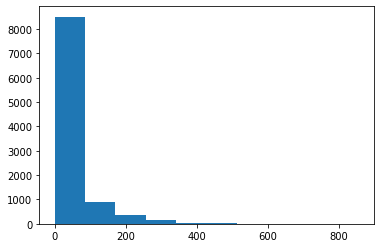

In [58]:
cloneSizes = np.concatenate(result)
plt.hist(cloneSizes)

In [59]:
print(np.mean(cloneSizes))

36.662


In [60]:
%time mu = firstIncompleteMoment(cloneSizes)

CPU times: user 2.01 s, sys: 22.2 ms, total: 2.04 s
Wall time: 2.05 s


slope = -0.007421543565488379


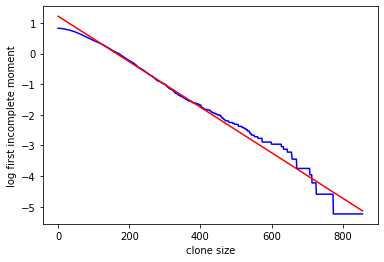

In [61]:
cloneSizeRange = np.asarray(range(int(max(cloneSizes))))
logPlot(cloneSizeRange,mu)

In [74]:
def tertiaryPassage(primaryInject, parameters,seed):
    primaryHarvest = harvestClones(primaryInject, parameters,80,seed)
    secondaryInject = transplantation(primaryHarvest)
    secondaryHarvest = harvestClones(secondaryInject, parameters,65,seed)
    tertiaryInject = transplantation(secondaryHarvest)
    tertiaryHarvest = harvestClones(tertiaryInject, parameters,70,seed)
    cloneSize = tertiaryHarvest["stem"] + tertiaryHarvest["progenitor"] + tertiaryHarvest["differentiated"]
    return(cloneSize)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 11.4 s, sys: 117 ms, total: 11.5 s
Wall time: 11.7 s


(array([853.,  59.,  38.,  25.,   8.,   6.,   5.,   1.,   3.,   2.]),
 array([  0. ,  59.5, 119. , 178.5, 238. , 297.5, 357. , 416.5, 476. ,
        535.5, 595. ]),
 <a list of 10 Patch objects>)

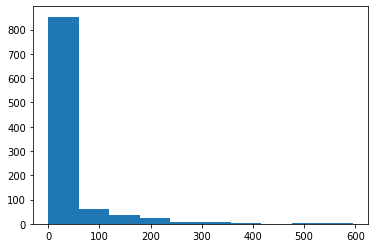

In [79]:
def multiTertiaryPassage(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = tertiaryPassage(primaryInject=primaryInject, parameters=parameters,seed=n*simulation+i)
    return(clones)

%time testing = multiTertiaryPassage(0)
plt.hist(testing)

In [80]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time result = p.map(multiTertiaryPassage, range(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in

CPU times: user 47.3 ms, sys: 16.7 ms, total: 64 ms
Wall time: 55.5 s


In [81]:
cloneSizes = np.concatenate(result)
print(np.mean(cloneSizes))

29.8501


In [82]:
cloneSizeRange = np.asarray(range(int(max(cloneSizes))))
%time mu = firstIncompleteMoment(cloneSizes)

CPU times: user 2.24 s, sys: 12.4 ms, total: 2.25 s
Wall time: 2.26 s


slope = -0.00594180267460805


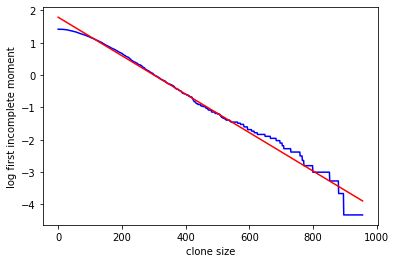

In [83]:
logPlot(cloneSizeRange,mu)

## Simulating the clonal grwoth till counting time point

final reaction time = 90.95573324500339
final clone size = 1


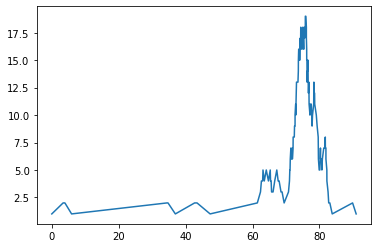

In [17]:
def clonalGrowthSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint):
    S = np.array([1])
    P = np.array([0])
    D = np.array([0])
    N = np.array([1])
    reactionTime = np.array([0])
    
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate
    
    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S[-1]*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S[-1]*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P[-1]*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P[-1]*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D[-1]*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)

#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
            elif r2 < (A1+A2+A3)/A0:
                P = np.append(P, P[-1]+1)
            elif r2 < (A1+A2+A3+A4)/A0:
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
            else:
                D = np.append(D, D[-1]-1)
            N = np.append(N, S[-1]+P[-1]+D[-1])
    print('final reaction time = ' + str(reactionTime[-1]))
    print('final clone size = ' + str(N[-1]))
    clonalGrowth = np.concatenate((reactionTime, N), axis=0)
    return{"reaction_time": reactionTime, "clone_size": N}

testingGrowth = clonalGrowthSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=100)
plt.plot(testingGrowth["reaction_time"],testingGrowth["clone_size"])